# Regression Analysis with Sampling
- Using SMOGN to sample data and make better predictions
- This is the best performing model. Modeling.ipynb doesn't use sampling so ignore, but this work is based on that nb.

In [7]:
# !pip install smogn

In [1]:
import smogn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

from xgboost import XGBRegressor


In [2]:
## read in data, drop cols, separate into X, y
df = pd.read_csv("data/dataModel.csv").dropna()
df.head()

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10694,0.838,0.256,1989.0,17.0,0.537,0.810,8.0,-6.213,0.0,0.1290,0.000709,0.892000,0.0579,0.667,134.096,136933.0,4.0
1,4528,0.955,0.867,0.0,1.0,0.342,0.377,11.0,-13.728,1.0,0.0401,0.943000,0.106000,0.1220,0.506,76.672,256827.0,3.0
2,3297,0.056,0.748,0.0,0.0,0.663,0.614,2.0,-7.712,1.0,0.2490,0.077100,0.006890,0.2960,0.248,82.060,87800.0,4.0
3,4435,0.740,1.000,0.0,26.0,0.163,0.262,1.0,-9.781,1.0,0.0306,0.792000,0.167000,0.1160,0.278,170.527,205347.0,4.0
4,4319,0.673,0.582,0.0,0.0,0.262,0.753,9.0,-11.859,1.0,0.0987,0.330000,0.000009,0.7180,0.087,138.553,101947.0,4.0


In [3]:
## custom train test split?
import random

def custom_split(data, test_prop=0.2):
    random.seed(699)

    train_prop = (1-test_prop)
    test_prop = test_prop

    num_train = round(len(df) * train_prop)
    num_test = round(len(df) * test_prop)

    train_idx = random.sample(range(0, len(df)-1), num_train)
    test_idx = random.sample(range(0, len(df)-1), num_test)

    _X_train = data.iloc[train_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_train = data.iloc[train_idx]["Popularity"].reset_index(drop=True)

    _X_test = data.iloc[test_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_test = data.iloc[test_idx]["Popularity"].reset_index(drop=True)

    print(len(df) == len(train_idx) + len(test_idx))

    return _X_train, _X_test, _y_train, _y_test

In [152]:
## make the split with the custom function
X_train, X_test, y_train, y_test = custom_split(df, test_prop=0.2)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=699)

True


In [153]:
df_train = X_train.join(y_train).sample(5000).reset_index(drop=True)

df_train.Popularity.describe()
# df_train.isnull().sum()
# y_train.isnull().sum()

rg_mtrx = [
    [10, 0, 0],
    [38, 1, 0],
    [45, 1, 0],
    [100, 1, 0]
]

In [233]:
df_smogn = smogn.smoter(
    data = df_train,
    y = "Popularity",
    k = 5,
    rel_thres=0.7,
    samp_method = "extreme"
    # rel_xtrm_type = "high"
)

r_index: 100%|##########| 54/54 [00:00<00:00, 603.63it/s]


In [234]:
df_smogn

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Popularity
0,10087,0.277983,0.526839,2002.328365,0.599971,0.918657,8.671635,0.000,1.0,0.071941,0.084650,0.000000,0.228685,0.701314,147.508327,207083.365035,4.0,37.974026
1,10855,0.031303,0.878621,2002.946609,0.727948,0.961316,8.053391,0.000,1.0,0.129067,0.128236,0.000000,0.081234,0.745209,184.837317,207743.032011,4.0,37.974026
2,10592,0.115906,0.757972,2002.734572,0.684056,0.946685,8.265428,0.000,1.0,0.109474,0.113287,0.000000,0.131805,0.730155,172.034739,207516.788616,4.0,37.974026
3,10178,0.248819,0.568428,2002.401456,0.615101,0.923700,8.598544,0.000,1.0,0.078694,0.089803,0.000000,0.211253,0.706503,151.921484,207161.353060,4.0,37.974026
4,9817,0.458644,0.326644,2000.488014,0.546112,0.894236,8.244007,0.000,1.0,0.041155,0.064054,0.035448,0.289864,0.700176,124.648873,206775.587597,4.0,35.436620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9171,0.742000,0.557000,0.000000,0.533000,0.497000,3.000000,-7.363,1.0,0.038700,0.172000,0.000005,0.053200,0.934000,96.803000,187813.000000,4.0,7.000000
4996,8480,0.695000,1.000000,0.000000,0.773000,0.562000,7.000000,-5.579,0.0,0.049200,0.147000,0.000580,0.099700,0.516000,119.964000,210747.000000,4.0,0.000000
4997,8473,0.792000,0.111000,2003.000000,0.642000,0.862000,1.000000,-7.507,1.0,0.056500,0.003500,0.162000,0.102000,0.396000,139.971000,258453.000000,4.0,16.000000
4998,13322,0.396000,0.583000,2000.000000,0.317000,0.936000,2.000000,-6.880,1.0,0.091600,0.000266,0.679000,0.113000,0.232000,126.802000,191160.000000,4.0,16.000000


In [235]:
## split back into X_train, y_train
X_train = df_smogn.drop("Popularity", axis=1)
y_train = df_smogn.Popularity

In [236]:
## scale the data
# scaler = RobustScaler()
# X_train =  scaler.fit_transform(X_train)
# x_test = scaler.transform(X_test)

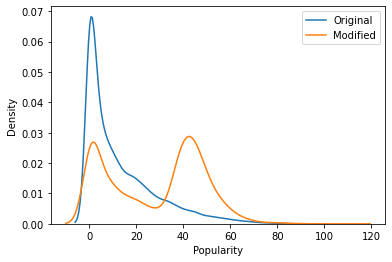

In [237]:
## distribution plot
sns.kdeplot(df['Popularity'], label = "Original")
sns.kdeplot(df_smogn['Popularity'], label = "Modified")
plt.legend();


### Dummy Regressor

In [238]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [239]:
dummy_train_r2 = dummy_reg.score(X_train, y_train)
dummy_test_r2 = dummy_reg.score(X_test, y_test)
dummy_preds = dummy_reg.predict(X_test)

dummy_RMSE = np.sqrt(mean_squared_error(y_test, dummy_preds))
dummy_MAE = mean_absolute_error(y_test, dummy_preds)

In [240]:
print(f'train r2: {dummy_train_r2}')
print(f'test r2: {dummy_test_r2}')
print(f'mae: {dummy_MAE}')
print(f'rmse: {dummy_RMSE}')
print(f'mse: {mean_squared_error(y_test, dummy_preds)}')

train r2: 0.0
test r2: -1.0452326083324137
mae: 19.35675775446267
rmse: 21.35460520522477
mse: 456.0191634710129


## Model Pipeline
After testing out many models, best performing ones are:
- Random Forest
- KNeighbors
- XGBoost
- Gradient Boosting Regressor (similar to xgboost)

- GS for best parameters

In [453]:
est1 = GradientBoostingRegressor(loss="lad", max_features=None,
                                 min_samples_split=4, max_depth=7)

est2 = RandomForestRegressor(bootstrap=False, max_features="sqrt",
                             min_samples_split=3, n_estimators=100)

est3 = KNeighborsRegressor(n_neighbors=5, weights="distance")

est4 = XGBRegressor(colsample_bytree=0.9, eval_metric="mae",
                        gamma=0.3, max_depth=3, min_child_weight=2,
                        objective="reg:squarederror", subsample=1.0)

stack_reg = StackingRegressor(estimators=[('est1', est2)
                                          # ('est2', est3)
                                          ],
                              final_estimator=est1)

## Let's prepare a pipeline for testing
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', stack_reg)
])

# pipe.fit(X_train, y_train)

In [454]:
# (-8.583437741074725,
#  {'reg__bootstrap': False,
#   'reg__max_features': 'sqrt',
#   'reg__min_samples_split': 3,
#   'reg__n_estimators': 100})
params_RF = {'reg__n_estimators': [100,200],
             'reg__max_features': ["log2", "sqrt", "auto"],
             'reg__min_samples_split': [2, 3, 4],
             'reg__bootstrap': [True, False]}

# (-9.79038707792391, {'reg__n_neighbors': 5, 'reg__weights': 'distance'})
params_KNN = {'reg__n_neighbors': [5, 8, 10],
              'reg__weights': ["uniform", "distance"]}

# (-9.026157811283062,
#  {'reg__colsample_bytree': 0.9,
#   'reg__eval_metric': 'mae',
#   'reg__gamma': 0.3,
#   'reg__max_depth': 3,
#   'reg__min_child_weight': 2,
#   'reg__objective': 'reg:squarederror',
#   'reg__subsample': 1.0})
params_XGB = {'reg__objective': ["reg:squarederror", "reg:linear"],
              'reg__eval_metric': ["mae", "rmse"],
              'reg__min_child_weight': [2,4,5],
              'reg__gamma':[i/10.0 for i in range(3,6)],
              'reg__subsample':[i/10.0 for i in range(6,11)],
              'reg__colsample_bytree':[i/10.0 for i in range(6,11)],
              'reg__max_depth': [2,3,4]}

# (-8.46321875834909,
#  {'reg__loss': 'lad',
#   'reg__max_depth': 7,
#   'reg__max_features': None,
#   'reg__min_samples_split': 4})
params_GBR = {'reg__loss': ["lad", "ls"],
              'reg__min_samples_split': [2, 4, 5],
              'reg__max_depth': [3, 5, 7],
              'reg__max_features': [None, 'auto', 'sqrt', 'log2']}

In [455]:
%%time
## gridsearch it with correct parameter grid

gs = GridSearchCV(pipe, param_grid={}, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train, y_train)

gs_preds = gs.predict(X_test)

CPU times: user 23.3 s, sys: 1.32 s, total: 24.6 s
Wall time: 50.6 s


In [457]:
gs.best_score_, gs.best_params_

(-8.802680222682495, {})

In [458]:

gs_RMSE = np.sqrt(mean_squared_error(y_test, gs_preds))
gs_MAE = mean_absolute_error(y_test, gs_preds)

print(f'mae: {gs_MAE}')
print(f'rmse: {gs_RMSE}')
print(f'mse: {mean_squared_error(y_test, gs_preds)}')

mae: 8.928815484850833
rmse: 13.347382268776435
mse: 178.1526134288476


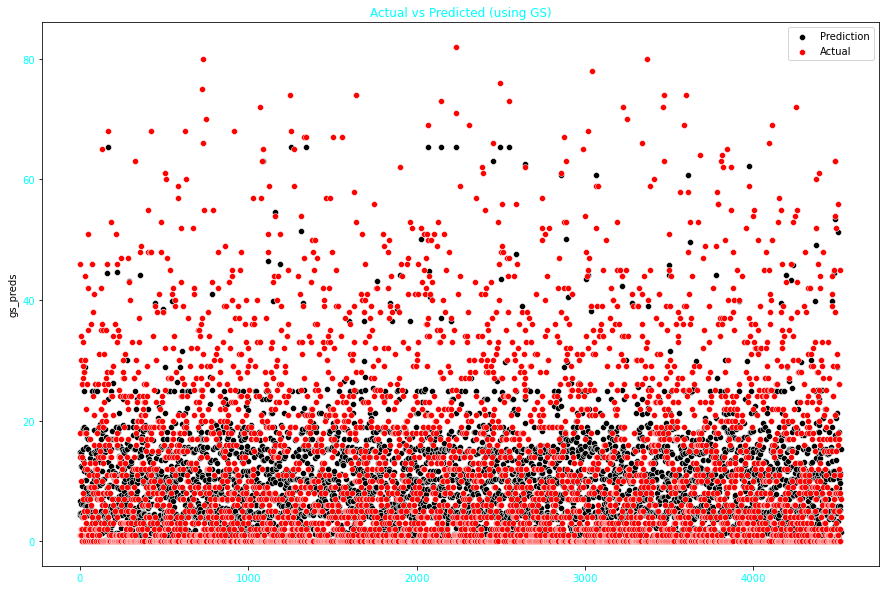

In [459]:
fig, ax = plt.subplots(figsize=(15,10))

preds_df = pd.DataFrame(list(zip(y_test, gs_preds)), columns=["y_test", "gs_preds"])
preds_df["absolute_error"] = preds_df["gs_preds"] - preds_df["y_test"]
preds_df

sns.scatterplot(x=preds_df.index, y="gs_preds", data=preds_df, ax=ax, color="black", label="Prediction")
# plt.plot(y_test - gs_preds, marker='o',linestyle='')
sns.scatterplot(x=preds_df.index, y="y_test", data=preds_df, ax=ax, color="red", label="Actual")

plt.title("Actual vs Predicted (using GS)", color="cyan");
plt.xticks(color="cyan")
plt.yticks(color="cyan");
